In [1]:
import sys
sys.path.append('..')

import utils, selex_dca, indep_sites
import adabmDCA
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

import torch
from utils import one_hot
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/Users/scrotti/Aptamer2025py/selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
dtype = torch.float32

## Generate

In [14]:
import importlib
importlib.reload(utils)
importlib.reload(selex_distribution)
importlib.reload(energy_models)
importlib.reload(sampling)
importlib.reload(training)
importlib.reload(callback)

<module 'callback' from '/Users/scrotti/Aptamer2025py/callback.py'>

In [15]:
L, q = 45, 4

tr = tree.Tree()
tr.add_node(-1, name = "round 1 with selection")
tr.add_node(0, name = "round 2 with selection")

selected_modes = torch.BoolTensor(
    [[1],
     [1]]
)

n_selection_rounds, n_modes = selected_modes.size()
assert n_selection_rounds == tr.get_n_nodes()
n_rounds = n_selection_rounds + 1

## Build wildtype

In [58]:
torch.manual_seed(0)

h_teacher = torch.randn(L, q, dtype=dtype)
J_teacher = utils.rand_coupling_matrix(L, q, dtype=dtype)
potts_teacher = energy_models.Potts(J_teacher, h_teacher)
ps_teacher = selex_distribution.MultiModeDistribution(potts_teacher, normalized=False).requires_grad_(False)
x = utils.rand_sequences_oh(10**4, L, q)
selected = torch.BoolTensor([1])
compute_energy = lambda x : ps_teacher.compute_energy(x, selected)

In [59]:
beta_schedule = torch.arange(0, 5, 0.5)
n_steps = 20

x, energies = sampling.simulated_annealing(x, compute_energy, n_steps, beta_schedule)
wt_oh = x[0]

In [60]:
mutation_rate = 0.3
k_teacher = utils.field_from_wildtype(wt_oh, mutation_rate)

Ns0_teacher = energy_models.IndepSites(k_teacher)
model_teacher = selex_distribution.MultiRoundDistribution(Ns0_teacher, ps_teacher, tr, selected_modes)
model_teacher.train(mode=False);

In [61]:
n_chains = 10**5
chains_teacher = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype)

In [62]:
n_sweeps = 20
energies = model_teacher.sample(chains_teacher, n_sweeps)

In [63]:
# plt.hist(energies[0]);
# plt.axvline(model_teacher.compute_energy_up_to_round(wt_oh.unsqueeze(0), 0).item())

## Learn

In [95]:
sequences_oh = chains_teacher
total_reads = total_reads = torch.Tensor([sequences_oh.shape[1] for _ in range(n_rounds)])

In [96]:
k = torch.randn(L, q, dtype=dtype)
h = torch.randn(L, q, dtype=dtype)
J = utils.rand_coupling_matrix(L, q, dtype=dtype, rescaling=1e-4)

Ns0 = energy_models.IndepSites(k)
ps = selex_distribution.MultiModeDistribution(energy_models.Potts(J, h), normalized=False)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)

In [97]:
batch_size = 10**4
data_loaders = [data_loading.SelexRoundDataLoader(sequences_oh[id], batch_size=batch_size, device=torch.device('cpu')) 
                for id in range(n_rounds)]

In [98]:
n_chains = 10**4
chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype)
log_weights = torch.zeros(n_rounds, n_chains, dtype=dtype)

In [99]:
callbacks = [callback.ConvergenceMetricsCallback(), callback.TeacherStudentCallback(model_teacher)]

In [100]:
lr = 0.05
weight_decay = 0.0
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

In [ ]:
n_sweeps = 10
target_pearson = 1
max_epochs = 4000

training.train(model, data_loaders, total_reads, chains, n_sweeps, max_epochs, target_pearson, 
               callbacks=callbacks, log_weights=log_weights, lr=lr,
               optimizer=optimizer)

 0.00%[                                                        ] Epoch: 0/4000 [00:00, ?it/s]

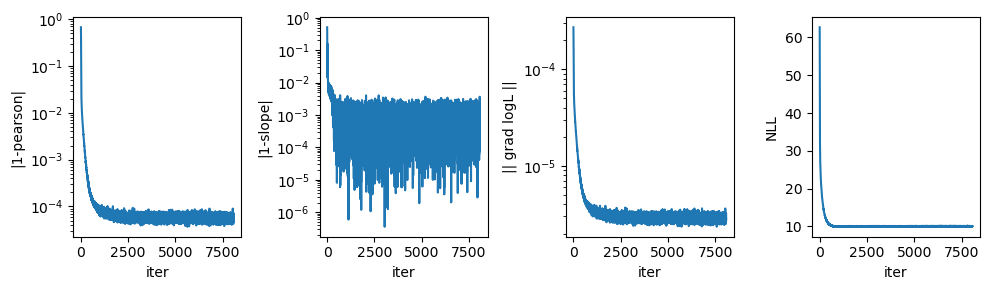

In [167]:
callbacks[0].plot();

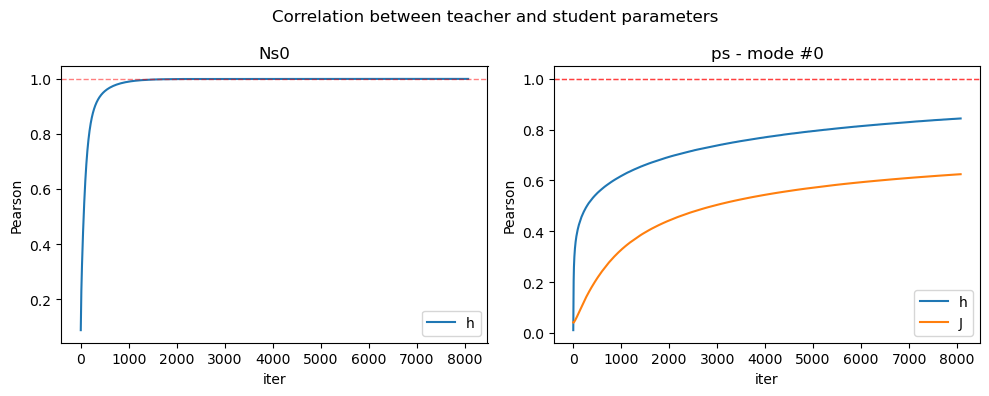

In [168]:
callbacks[1].plot_pearson_parameters();

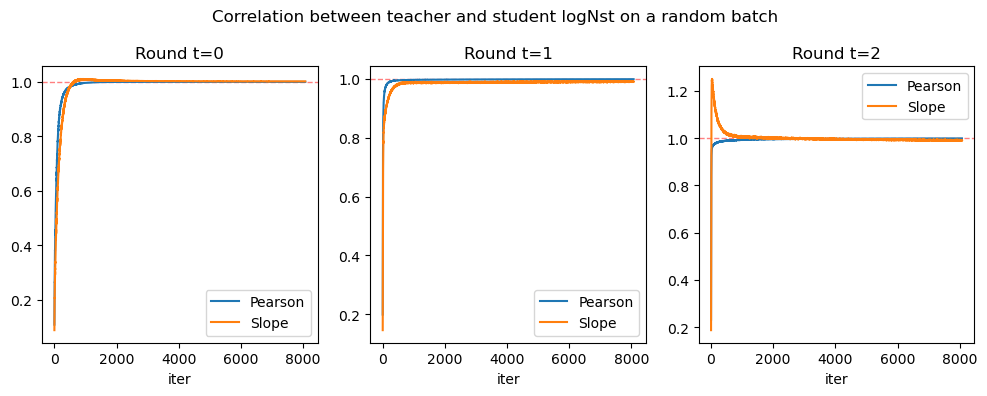

In [169]:
callbacks[1].plot_pearson_energies();

0.9999450445175171

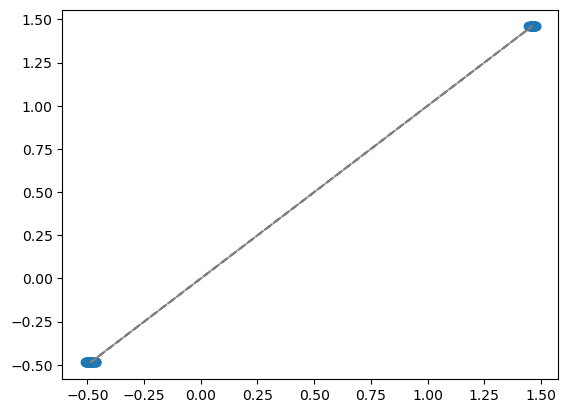

In [170]:
X = model.round_zero.set_zerosum_gauge().h.detach().reshape(-1)
Y = model_teacher.round_zero.set_zerosum_gauge().h.detach().reshape(-1)
plt.plot(Y, Y,ls='--', color='gray', alpha=1)
plt.scatter(X, Y)
torch.corrcoef(torch.stack([X,Y]))[0,1].item()

0.8442147374153137

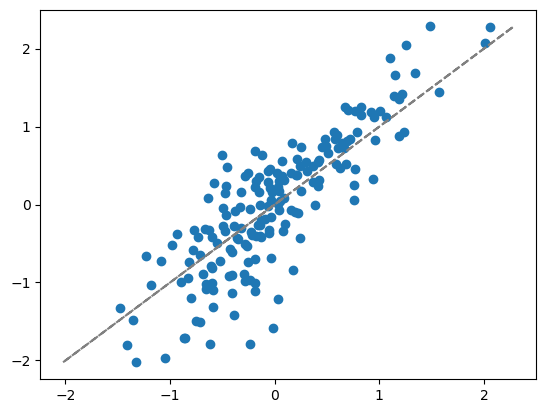

In [171]:
X = model.selection.modes[0].set_zerosum_gauge().h.detach().reshape(-1)
Y = model_teacher.selection.modes[0].set_zerosum_gauge().h.detach().reshape(-1)
plt.plot(Y, Y,ls='--', color='gray', alpha=1)
plt.scatter(X, Y)
torch.corrcoef(torch.stack([X,Y]))[0,1].item()

0.6247765421867371

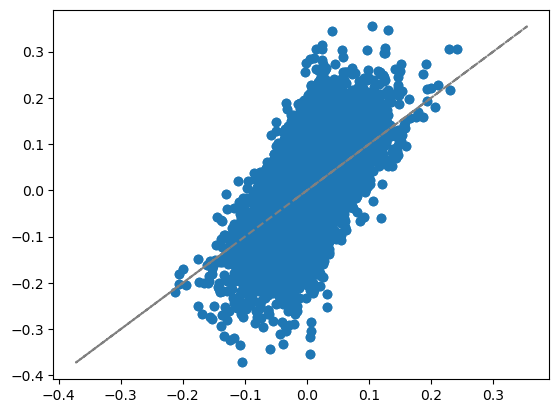

In [172]:
X = utils.off_diagonal_terms(model.selection.modes[0].set_zerosum_gauge().J.detach())
Y = utils.off_diagonal_terms(model_teacher.selection.modes[0].set_zerosum_gauge().J.detach())
plt.plot(Y, Y,ls='--', color='gray', alpha=1)
plt.scatter(X, Y)
torch.corrcoef(torch.stack([X,Y]))[0,1].item()

## Compute energies for sequences far away from the wildtype

In [173]:
def hamming(x:torch.tensor, y: torch.tensor):
    L = x.size(-2)
    return L - (x * y).sum((-2, -1)).to(torch.int)

In [174]:
wt_far_oh = one_hot(torch.randint(q, (L,)))
k_far = utils.field_from_wildtype(wt_far_oh, mutation_rate)
hamming(wt_oh, wt_far_oh)

tensor(35, dtype=torch.int32)

In [175]:
X_far = sampling.sample_indep_sites(k_far, n_samples=chains_teacher[0].size(0))
X_close = sequences_oh[0]

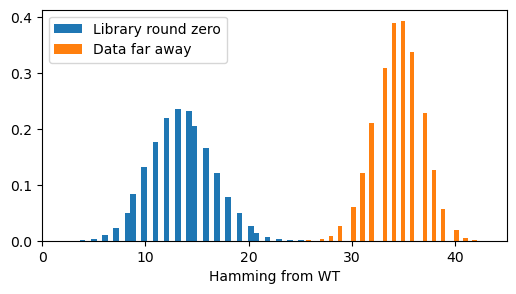

In [176]:
fig, ax = plt.subplots(figsize=(6,3))
ax.hist(hamming(wt_oh, X_close), label='Library round zero', bins=L+1, density=True)
ax.hist(hamming(wt_oh, X_far), label='Data far away', bins=L+1, density=True)
ax.set_xlabel('Hamming from WT')
ax.legend();

POTTS


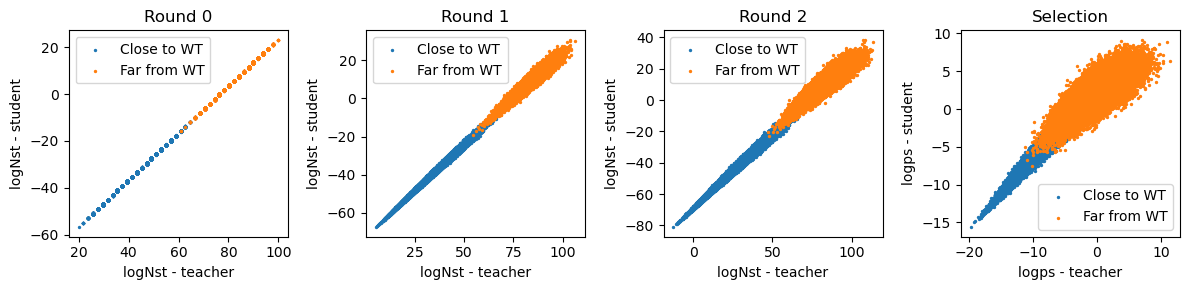

In [177]:
fig, axes = plt.subplots(1, n_rounds+1, figsize=(12, 3))

for t in range(n_rounds):
    ax = axes[t]
    en_teacher = model_teacher.compute_energy_up_to_round(X_close, t).detach()
    en_student = model.compute_energy_up_to_round(X_close, t).detach()
    ax.scatter(en_teacher, en_student, label='Close to WT', s=2)
    en_teacher = model_teacher.compute_energy_up_to_round(X_far, t).detach()
    en_student = model.compute_energy_up_to_round(X_far, t).detach()
    ax.scatter(en_teacher, en_student, label='Far from WT', s=2)
    ax.legend()
    ax.set_xlabel('logNst - teacher'); ax.set_ylabel('logNst - student')
    ax.set_title(f'Round {t}')
    
ax = axes[-1]
en_teacher = model_teacher.selection_energy_at_round(X_close, 1).detach()
en_student = model.selection_energy_at_round(X_close, 1).detach()
ax.scatter(en_teacher, en_student, label='Close to WT', s=2)
en_teacher = model_teacher.selection_energy_at_round(X_far, 1).detach()
en_student = model.selection_energy_at_round(X_far, 1).detach()
ax.scatter(en_teacher, en_student, label='Far from WT', s=2)
ax.legend()
ax.set_xlabel('logps - teacher'); ax.set_ylabel('logps - student')
ax.set_title(f'Selection')
fig.tight_layout()

print('POTTS')

## Binning

In [181]:
sequences_unique_all_oh, counts_unique, enrichments = utils.unique_sequences_counts_enrichments(sequences_oh)

Extracting unique sequences and counts at each round...
Merging sequences from all rounds in a single container...
Assigning counts at each round to unique sequences...
	Starting round 0...
	Starting round 1...
	Starting round 2...
Calculating enrichments...
Finished


In [192]:
import importlib
importlib.reload(utils)

<module 'utils' from '/Users/scrotti/Aptamer2025py/utils.py'>

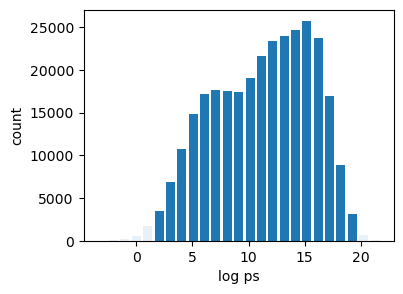

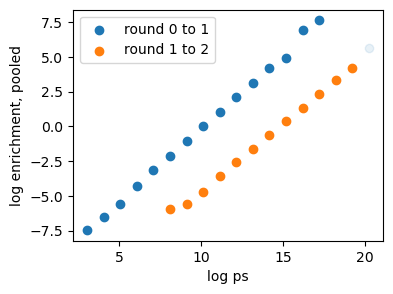

In [193]:
utils.binned_logenrichments(model, sequences_unique_all_oh, counts_unique, n_bins = 25, plot=True, thresh=0.01);

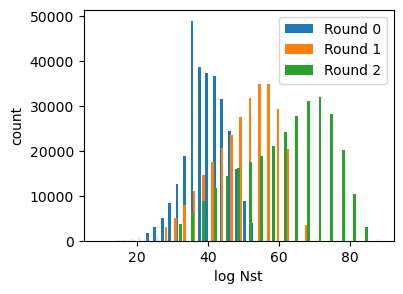

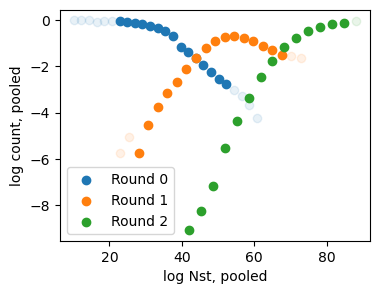

In [194]:
utils.binned_logcounts(model, sequences_unique_all_oh, counts_unique, n_bins = 25, plot=True, thresh=0.01);

## Generate from learned model

In [526]:
n_sweeps = 20
n_chains = 10**5
chains_student = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype)
_ = model.sample(chains_student, n_sweeps)

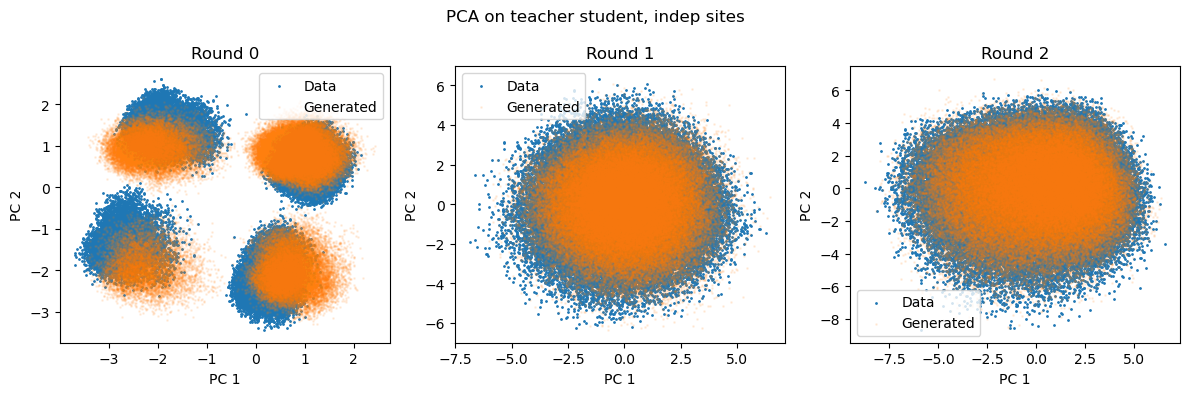

In [534]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))
markersize = 1
for t in range(n_rounds):
    pcs_gen, pcs_data = utils.compute_pca(chains_student[t], sequences_oh[t])
    ax = axes[t]
    ax.scatter(pcs_data[:,0], pcs_data[:,1], label='Data', s=markersize)
    ax.scatter(pcs_gen[:,0], pcs_gen[:,1], label='Generated', s=markersize, alpha=0.1)
    ax.set_xlabel('PC 1'); ax.set_ylabel('PC 2')
    ax.set_title(f'Round {t}')
    ax.legend()
fig.suptitle('PCA on teacher student, indep sites')
fig.tight_layout()

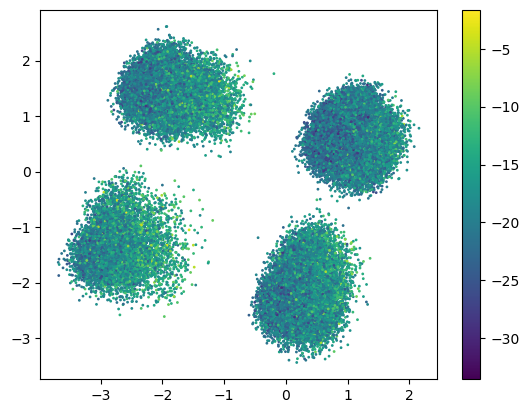

In [533]:
t = 0
pcs, _ = utils.compute_pca(sequences_oh[t], chains_student[t])
energies = model_teacher.compute_energy_up_to_round(sequences_oh[t], t).detach()
plt.scatter(pcs[:,0], pcs[:,1], label='Data', s=markersize, c=energies)
plt.colorbar()